In [1]:
import pandas as pd
import lightgbm as lgb
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from lightgbm import plot_importance

In [2]:
train = pd.read_csv('../../week02/Eunhee/input_training.csv')
test = pd.read_csv('../../week02/Eunhee/input_testing.csv')

In [3]:
def LabelEncoding(train_df,test_df,max_levels=2):
    for col in train_df:
        if train_df[col].dtype == 'object':
            if len(list(train_df[col].unique())) <= max_levels:
                le = preprocessing.LabelEncoder()
                le.fit(train_df[col])
                train_df[col]=le.transform(train_df[col])
                test_df[col]=le.transform(test_df[col])
    return [train_df,test_df]
def readInputAndEncode(input_path,train_file,test_file,target_column):
    training=pd.read_csv(input_path+train_file)
    testing=pd.read_csv(input_path+test_file)

    training,testing=LabelEncoding(training,testing)

    #print("Training Data Shape after Encoding ",training.shape)
    #print("Testing Data Shape after Encoding ",testing.shape)
    #Check if all train columns are there in test data. If not add the column to test data and replace it with zero
    train_cols=training.columns.tolist()
    test_cols=testing.columns.tolist()
    col_in_train_not_test=set(train_cols)-set(test_cols)
    for col in col_in_train_not_test:
        if col!=target_column:
            testing[col]=0
    col_in_test_not_train=set(test_cols)-set(train_cols)
    for col in col_in_test_not_train:
        training[col]=0
    print("Training Data Shape after Processing ",training.shape)
    print("Testing Data Shape after Processing ",testing.shape)
    return [training,testing]

In [4]:
train,test=readInputAndEncode("../../week02/Eunhee/",'input_training.csv','input_testing.csv','log_trip_duration')
train.drop(['pickup_date'],axis=1,inplace=True)
test.drop(['pickup_date'],axis=1,inplace=True)
train.drop(['pickup_datetime'],axis=1,inplace=True)
test.drop(['pickup_datetime'],axis=1,inplace=True)
test_id=test['id']
train.drop(['id'],axis=1,inplace=True)
test.drop(['id'],axis=1,inplace=True)
train.drop(['vendor_id'], axis=1, inplace=True)
test.drop(['vendor_id'], axis=1, inplace=True)

Training Data Shape after Processing  (1458644, 18)
Testing Data Shape after Processing  (625134, 17)


In [5]:
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].astype('category')
train['pickup_neighbourhood'] = train['pickup_neighbourhood'].astype('category')
train['dropoff_neighbourhood'] = train['dropoff_neighbourhood'].astype('category')

test['store_and_fwd_flag'] = test['store_and_fwd_flag'].astype('category')
test['pickup_neighbourhood'] = test['pickup_neighbourhood'].astype('category')
test['dropoff_neighbourhood'] = test['dropoff_neighbourhood'].astype('category')

In [6]:
raw_x = train[['passenger_count','store_and_fwd_flag','pickup_day','pickup_hour','pickup_day_of_week','pickup_latitude_round3','pickup_longitude_round3','dropoff_latitude_round3','dropoff_longitude_round3','trip_distance','bearing','pickup_neighbourhood','dropoff_neighbourhood']]
raw_y = train[['log_trip_duration']]

In [7]:
train_x,test_x, train_y, test_y = train_test_split(raw_x, raw_y, test_size=0.2, random_state=42)

In [8]:
model_lgb = lgb.LGBMRegressor(n_estimators=400, objective='regression', learning_rate=0.05, max_depth=25,
                              num_leaves=1000, num_iterations=200)

In [9]:
model_lgb.fit(train_x, train_y)

LGBMRegressor(learning_rate=0.05, max_depth=25, n_estimators=400,
              num_iterations=200, num_leaves=1000, objective='regression')

In [10]:
pred_lgb = model_lgb.predict(test_x)

In [11]:
model_lgb.score(test_x, test_y)

0.756955995457591

In [12]:
model_lgb.score(train_x, train_y)

0.8118287764152644

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

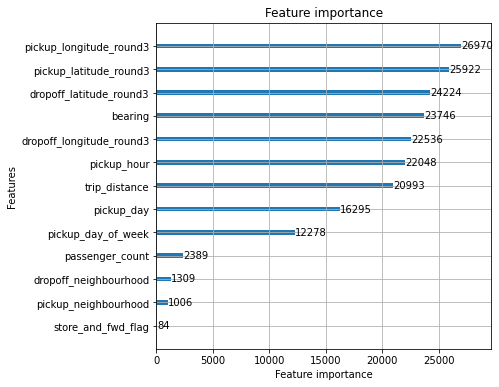

In [13]:
%matplotlib inline
f, ax = plt.subplots(figsize=(6,6))
plot_importance(model_lgb, max_num_features=len(train_x.columns), ax=ax)